#### Import libraries

In [15]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

##### Add project root to path for module imports

In [16]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, PROJECT_ROOT)

##### Import the shared K-Means tool

In [17]:
from modules.tool_kmeans import run_kmeans, find_optimal_k

#### Load data

"""
    Load the Student Performance dataset.
    
    Parameters
    ----------
    filepath : str
        Path to the CSV file.
    
    Returns
    -------
    pandas.DataFrame
        Loaded dataset.
"""

In [18]:
def load_data(filepath):
    print(f"\n{'='*60}")
    print("DATA LOADING")
    print(f"{'='*60}")
    
    df = pd.read_csv(filepath)
    print(f"✓ Loaded dataset from: {filepath}")
    print(f"✓ Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumns: {list(df.columns)}")
    
    return df

#### Target Creation

"""
    Create the PassFail target column based on G3 grade.
    
    Logic: G3 >= 10 → Pass (1), G3 < 10 → Fail (0)
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe with G3 column.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with PassFail column added.
    """

In [19]:
def create_target_column(df):
    print(f"\n{'='*60}")
    print("TARGET CREATION")
    print(f"{'='*60}")
    
    # Convert G3 to numeric (handles quoted values)
    df['G3'] = pd.to_numeric(df['G3'], errors='coerce')
    
    # Create PassFail column: G3 >= 10 → Pass (1), else Fail (0)
    df['PassFail'] = (df['G3'] >= 10).astype(int)
    
    print(f"✓ Created 'PassFail' column from 'G3' grade")
    print(f"  - Pass (G3 >= 10): {(df['PassFail'] == 1).sum()} students")
    print(f"  - Fail (G3 < 10): {(df['PassFail'] == 0).sum()} students")
    print(f"  - Pass Rate: {(df['PassFail'].mean() * 100):.1f}%")
    
    return df

#### Preproccesing

##### Hanling Missing values 

"""
    Check and handle missing values in the dataset.
    
    - Numeric columns: Fill with mean
    - Categorical columns: Fill with mode
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with missing values handled.
    """

In [20]:
def handle_missing_values(df):
    print(f"\n{'='*60}")
    print("MISSING VALUES HANDLING")
    print(f"{'='*60}")
    
    missing = df.isnull().sum()
    total_missing = missing.sum()
    
    if total_missing == 0:
        print("✓ No missing values found in the dataset!")
    else:
        print(f"⚠ Found {total_missing} missing values:")
        print(missing[missing > 0])
        
        # Numeric columns: fill with mean
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().any():
                df[col].fillna(df[col].mean(), inplace=True)
                print(f"  - Filled '{col}' with mean")
        
        # Categorical columns: fill with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df[col].isnull().any():
                df[col].fillna(df[col].mode()[0], inplace=True)
                print(f"  - Filled '{col}' with mode")
        
        print(f"✓ All missing values handled!")
    
    return df

##### Handling Dupliacte values

    """
    Check for and remove duplicate rows in the dataset.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe with duplicates removed.
    """

In [21]:
def handle_duplicates(df):
    print(f"\n{'='*60}")
    print("DUPLICATE CHECK")
    print(f"{'='*60}")
    
    # Check for duplicates
    duplicate_count = df.duplicated().sum()
    
    if duplicate_count == 0:
        print("✓ No duplicate rows found.")
    else:
        print(f"⚠ Found {duplicate_count} duplicate rows!")
        
        # Remove duplicates
        initial_rows = df.shape[0]
        df = df.drop_duplicates()
        current_rows = df.shape[0]
        
        print(f"  - Removed {duplicate_count} rows")
        print(f"  - Rows: {initial_rows} → {current_rows}")
        print("✓ Duplicates handled.")
        
    return df

##### Feature Encoding

"""
    Apply Label Encoding to all categorical columns.
    
    Converts string values to integers (e.g., 'F' -> 0, 'M' -> 1)
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with encoded categorical features.
    """

In [22]:
def encode_categorical_features(df):
    print(f"\n{'='*60}")
    print("FEATURE ENCODING")
    print(f"{'='*60}")
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if len(categorical_cols) == 0:
        print("✓ No categorical columns to encode")
        return df
    
    print(f"Found {len(categorical_cols)} categorical columns:")
    print(f"  {categorical_cols}")
    
    # Apply Label Encoding
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ Encoded '{col}': {list(le.classes_)} → {list(range(len(le.classes_)))}")
    
    print(f"\n✓ All {len(categorical_cols)} categorical columns encoded successfully!")
    
    return df

#### Complete Preprocessing pipline

    """
    Complete preprocessing pipeline for Student Performance data.
    
    Steps:
    1. Create PassFail target from G3
    2. Handle missing values
    3. Encode categorical features
    4. Drop G3 column (already captured in PassFail)
    
    Parameters
    ----------
    df : pandas.DataFrame
        Raw student dataframe.
    
    Returns
    -------
    pandas.DataFrame
        Cleaned dataframe ready for clustering.
    """

In [23]:
def preprocess_data(df):
    # Step 1: Create target column
    df = create_target_column(df)
    
    # Step 2: Handle missing values
    df = handle_missing_values(df)
    
    # Step 3 : Handle Duplicates
    df = handle_duplicates(df)
    
    # Step 4: Encode categorical features
    df = encode_categorical_features(df)
    
    # Step 4: Drop G3 (we have PassFail now)
    if 'G3' in df.columns:
        df = df.drop(columns=['G3'])
        print(f"\n✓ Dropped 'G3' column (already captured in 'PassFail')")
    
    # Final check
    print(f"\n{'='*60}")
    print("PREPROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Final dataset shape: {df.shape}")
    print(f"All columns numeric: {df.select_dtypes(include=['object']).empty}")
    print(f"Columns: {list(df.columns)}")
    
    return df

#### Main Function


STUDENT PERFORMANCE - K-MEANS CLUSTERING ANALYSIS
Education Domain Implementation

DATA LOADING
✓ Loaded dataset from: d:\data minig\K-means-algo\implement\Data-Mining-Project\domains\education\data\student-por.csv
✓ Shape: 649 rows × 33 columns

Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

First 5 rows of raw data:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  

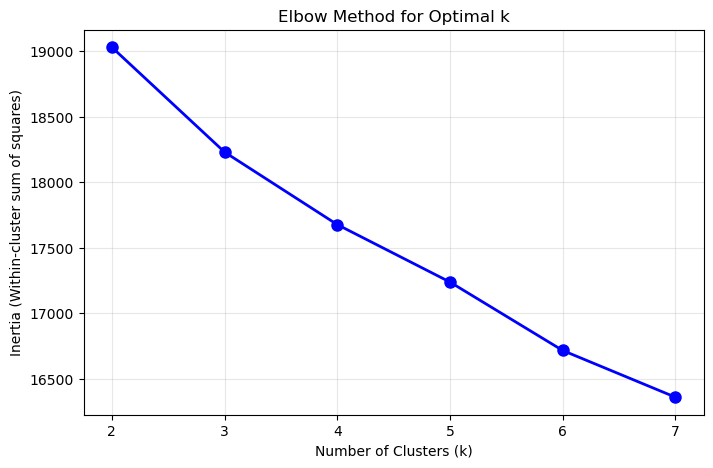


Elbow Analysis Results:
  k=2: Inertia = 19030.44
  k=3: Inertia = 18230.16
  k=4: Inertia = 17676.47
  k=5: Inertia = 17237.84
  k=6: Inertia = 16715.61
  k=7: Inertia = 16358.97

RUNNING K-MEANS CLUSTERING (k=3)

K-MEANS CLUSTERING ANALYSIS

✓ Dropped target column: 'PassFail'
✓ Number of features: 32
✓ Number of samples: 649
✓ Applied StandardScaler to normalize features
✓ K-Means fitted with 3 clusters

CLUSTERING RESULTS

Cluster Distribution:
  Cluster 0: 240 samples (37.0%)
  Cluster 1: 154 samples (23.7%)
  Cluster 2: 255 samples (39.3%)

Cluster Centers (Scaled Values):
           school    sex    age  address  famsize  Pstatus   Medu   Fedu   Mjob   Fjob  reason  guardian  traveltime  studytime  failures  schoolsup  famsup   paid  activities  nursery  higher  internet  romantic  famrel  freetime  goout   Dalc   Walc  health  absences     G1     G2
Cluster 0   0.082 -0.461 -0.156   -0.065   -0.082   -0.005 -0.568 -0.480 -0.391 -0.140  -0.028    -0.125       0.098      0.159  

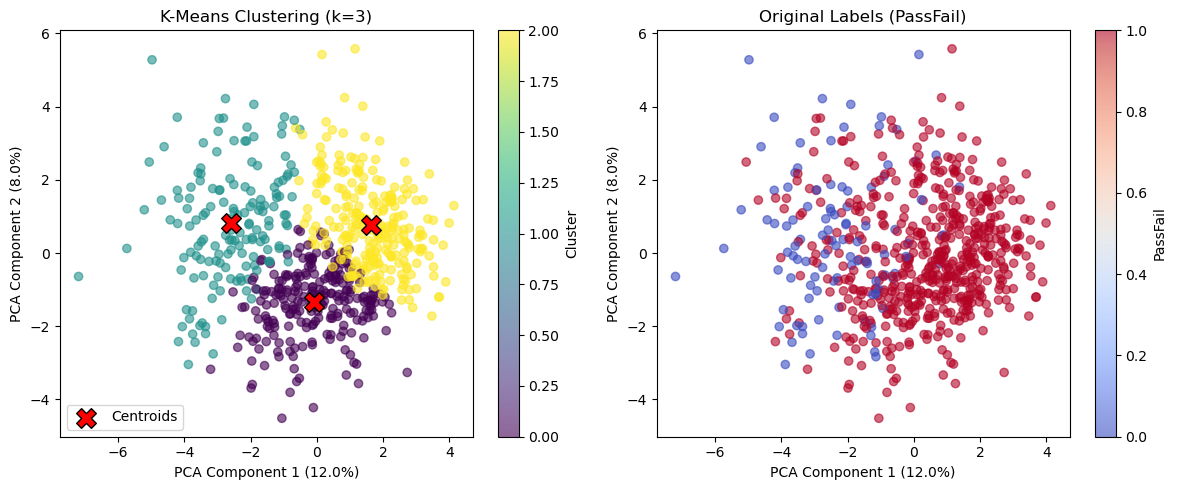


CLUSTER ANALYSIS

Mean values per cluster (selected features):
           age  studytime  failures  absences     G1     G2  PassFail
Cluster                                                              
0        16.55       2.06      0.07      3.07  11.54  11.73      0.91
1        17.39       1.49      0.79      4.69   8.64   8.75      0.53
2        16.53       2.07      0.03      3.59  12.93  13.13      0.97

✓ Results saved to 'd:\data minig\K-means-algo\implement\Data-Mining-Project\domains\education\outputs\clustering_results.csv'

ANALYSIS COMPLETE!

Output files saved in: d:\data minig\K-means-algo\implement\Data-Mining-Project\domains\education\outputs
  - elbow_method.png
  - kmeans_results.png
  - clustering_results.csv


In [25]:
def main():
    print("\n" + "="*60)
    print("STUDENT PERFORMANCE - K-MEANS CLUSTERING ANALYSIS")
    print("Education Domain Implementation")
    print("="*60)
    
    # Paths
    script_dir = os.getcwd()
    data_path = os.path.join(os.getcwd(), 'data', 'student-por.csv')
    output_dir = os.path.join(script_dir, 'outputs')
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load data
    df = load_data(data_path)
    
    # Display initial data info
    print(f"\nFirst 5 rows of raw data:")
    print(df.head())
    
    # Preprocess data
    df_cleaned = preprocess_data(df)
    
    # Display cleaned data info
    print(f"\nFirst 5 rows of cleaned data:")
    print(df_cleaned.head())
    
    # Find optimal number of clusters (Elbow Method)
    print(f"\n{'='*60}")
    print("FINDING OPTIMAL NUMBER OF CLUSTERS")
    print(f"{'='*60}")
    elbow_results = find_optimal_k(
        df_cleaned, 
        target_column='PassFail', 
        k_range=range(2, 8),
        save_path=output_dir
    )
    print("\nElbow Analysis Results:")
    for k, inertia in elbow_results.items():
        print(f"  k={k}: Inertia = {inertia:.2f}")
    
    # Run K-Means clustering with 3 clusters
    print(f"\n{'='*60}")
    print("RUNNING K-MEANS CLUSTERING (k=3)")
    print(f"{'='*60}")
    
    cluster_labels, centers, model = run_kmeans(
        df_cleaned, 
        target_column='PassFail', 
        n_clusters=3,
        visualize=True,
        save_path=output_dir
    )
    
    # Add cluster labels to dataframe
    df_cleaned['Cluster'] = cluster_labels
    
    # Analyze clusters
    print(f"\n{'='*60}")
    print("CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    # Show mean values for key features per cluster
    cluster_means = df_cleaned.groupby('Cluster').mean()
    important_features = ['age', 'studytime', 'failures', 'absences', 'G1', 'G2', 'PassFail']
    available_features = [f for f in important_features if f in cluster_means.columns]
    print("\nMean values per cluster (selected features):")
    print(cluster_means[available_features].round(2))
    
    # Save results
    results_path = os.path.join(output_dir, 'clustering_results.csv')
    df_cleaned.to_csv(results_path, index=False)
    print(f"\n✓ Results saved to '{results_path}'")
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE!")
    print(f"{'='*60}")
    print(f"\nOutput files saved in: {output_dir}")
    print("  - elbow_method.png")
    print("  - kmeans_results.png")
    print("  - clustering_results.csv")


if __name__ == "__main__":
    main()